## Linear Regression

Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

---

#### Load dependencies

In [109]:
# This will help us to measure the time it took for the whole
# notebook to execute
import time
start_time = time.time()

import os
import importlib
import sys
sys.path.append('../../utils')
import datasets
importlib.reload(datasets)
import helpers
importlib.reload(helpers)

import numpy as np
from sklearn import datasets

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


#### Get dataset

In [110]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [111]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [112]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance (x<sub>0</sub> = 1):

In [113]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]
len(X_with_bias)

150

Adding seed to make it reproducible

In [114]:
np.random.seed(2042)

#### Create a training datasets

Manually create a training, a validation, and a test dataset.

No Scikit-Learn

In [115]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)
print(f'Total size:         {total_size}')

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size
print(f'Test size:          {test_size}')
print(f'Validation size:    {validation_size}')
print(f'Train size:         {train_size}')
print('')

rnd_indices = np.random.permutation(total_size)
print('Random Indices: ')
print(rnd_indices)
print('')

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

Total size:         150
Test size:          30
Validation size:    30
Train size:         90

Random Indices: 
[ 33  99 147  53  88  22  65  52  50  49  91 103  12  68  82 108  76  61
  45 107  85  58  80 137  16  43  34 117   6  74 118  17 128  66  59 122
  78  44  25  51 125 124 136 134   5 110  40 100 114 133 126  36   2  92
  96 105   1  27  63   9 121  41  60  89 112 120 132  10  18  29 142  84
 143  77  31  73  14  56 106 115  69  23 109 123  37 113   3  42  28  24
  13 146  39  32  79 130 140  21  38  47  55  72 138 149  90  98 141  67
 104  93   4  54 135 101  86  35  19  87  64 119  70 139 102  81  71  62
  11  30   7 116  46  97 129  26  95  75 127 145 131   8 144  57   0 148
  48  20  83  15 111  94]



#### One-Hot Encoding

In one-hot encoding, each unique class label is represented as a binary vector:

- The vector has a length equal to the total number of classes.
- Only one element in this vector is set to 1 (indicating the class of the instance), and all other elements are 0.

So, in this example:

- The class **0** is represented as **[1, 0, 0]**.
- The class **1** is represented as **[0, 1, 0]**.
- The class **2** is represented as **[0, 0, 1]**.

In [116]:
def to_one_hot_for_test(y):
    n_classes = y.max() + 1                 # Finds the number of classes
    print(f'n_classes:  {n_classes}')
    m = len(y)                              # Number of instances in y
    print(f'm:          {m}')
    Y_one_hot = np.zeros((m, n_classes))    # Initializes an m x n_classes matrix with zeros
    print(f'Y_one_hot:')
    print(f'{Y_one_hot}')
    Y_one_hot[np.arange(m), y] = 1          # Sets the correct element in each row to 1
    return Y_one_hot

print(f'Class indices: {y_train[:10]}')
to_one_hot_for_test(y_train[:10])

Class indices: [0 1 2 1 1 0 1 1 1 0]
n_classes:  3
m:          10
Y_one_hot:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Create class probabilities matrix for all sets

In [117]:
def to_one_hot(y):
    n_classes = y.max() + 1                 # Finds the number of classes
    m = len(y)                              # Number of instances in y
    Y_one_hot = np.zeros((m, n_classes))    # Initializes an m x n_classes matrix with zeros
    Y_one_hot[np.arange(m), y] = 1          # Sets the correct element in each row to 1
    return Y_one_hot

Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

#### Softmax Function

$$
\sigma_{(s(\mathbf{x}))_k} = \frac{\exp(s_k(\mathbf{x}))}{\sum_{j=1}^{K} \exp(s_j(\mathbf{x}))}
$$



In [118]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

## Training

Define number of inputs and outputs to start training.

- `n_inputs = X_train.shape[1]` Returns 3 since there are two columns for features to test plus a bias column
- `_outputs = len(np.unique(y_train))` Returns the number of unique class labels which is 3

In [119]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

#### Cost Function

$$
J(\mathbf{\Theta}) = \dfrac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log \left( \hat{p}_k^{(i)} \right)
$$

#### Equation for gradients

$$
\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

#### Train model

Implements a gradient descent algorithm for training a model using a softmax activation function, and it aims to minimize the cross-entropy loss in a multi-class classification task

Variables and Constants:

- `eta = 0.01` - Learning rate: size of steps taken during gradient dscent update.
- `n_iterations = 5001` - Number of iterations. Will go through the entire dataset 5001 times.
- `m = len(X_train)` - Number of training examples. Training set size is used in calculating the average gradient.
- `epsilon = 1e-7` - A small value added to prevent taking the logarithm of zero. This helps avoid numerical issues during the calculation of the cross-entropy loss.



In [120]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928792
4500 0.41060071429187134
5000 0.3956780375390373


In [121]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Accuracy score

In [122]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

np.float64(0.9666666666666667)

#### Add l<sub>2</sub> regularization

In [123]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.489035124439786
4000 0.4889173621830818
4500 0.4888643337449302
5000 0.4888403120738818


Accuracy Score

In [124]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

np.float64(1.0)

#### Add early stopping

In [125]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.inf

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327977 early stopping!


Accuracy Score

In [126]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

np.float64(1.0)

Plot the model for the whole dataset

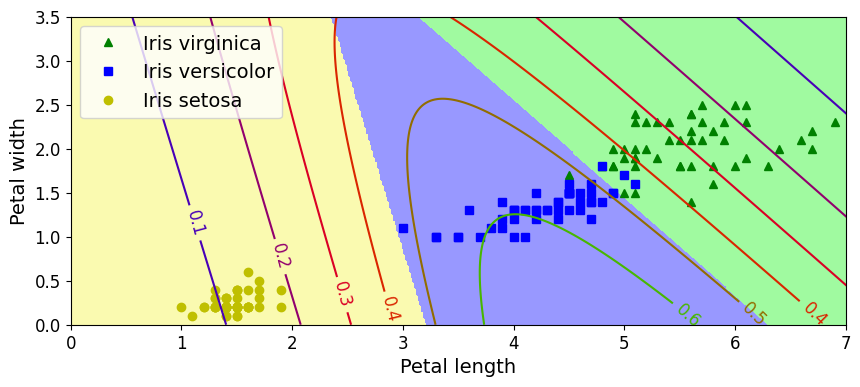

In [127]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

Final accuracy score

In [128]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

np.float64(0.9333333333333333)

---

## Total Time

This show the total time of execution

In [129]:
# Sets the total time of execution
end_time = time.time()
helpers.calculate_execution_time(start_time, end_time)

Total execution time: 0.0 minutes and 0.59 seconds
